# pylibCZIrw Demo

In this notebook one can see how to read and write czis using pylibCZIrw.

At the moment, pylibCZIrw completely abstracts away the subblock concept, both in the reading and in the writing APIs.
If pylibCZIrw is extended in the future to support subblock-based access (e.g. accessing acquisition tiles),
this API must not be altered.

## Reading a CZI file

Both the reading and writing APIs are contained within the czi object in pylibCZIrw, so let's start by importing it.

In [1]:
# !pip install ipyfilechooser

# show the used python env
import sys
sys.executable

from pylibCZIrw import czi as pyczi
from ipyfilechooser import FileChooser
import json
from matplotlib import pyplot as plt

### Open a czi

We can open a czi using a context manager and then read the required data.

In [2]:
# define the filename
czifile_scenes = r"w96_A1+A2.czi"
czifile_5dstack = r"T=3_Z=5_CH=2_X=240_Y=170.czi"

### Open a CZI image file read metadata

We can open a czi using a context manager and then read the required data.
The full metadata of the czi can be read as an XML or a dictionary

In [3]:
# get the raw metadata as XML
with pyczi.open_czi(czifile_5dstack) as czi_doc:
    md_xml = czi_doc.raw_metadata
    print(md_xml)

<?xml version="1.0"?>
<ImageDocument>
 <Metadata>
  <Experiment Version="1.1">
   <RunMode>OptimizeBeforePerformEnabled,ValidateAndAdaptBeforePerformEnabled</RunMode>
   <BeforeHardwareSetting>Before Exp [AF635, AF555, AF594, AF514, AF405, PGC] Smart</BeforeHardwareSetting>
   <AfterHardwareSetting>After Exp [AF635, AF555, AF594, AF514, AF405, PGC] Smart</AfterHardwareSetting>
   <ExperimentBlockIndex>0</ExperimentBlockIndex>
   <IsSegmented>false</IsSegmented>
   <IsStandardMode>true</IsStandardMode>
   <ImageTransferMode>MemoryMappedAndFileStream</ImageTransferMode>
   <AutoSave IsActivated="false" EnableSingleFileSave="false">
    <StorageFolder>D:\Users\zeiss\Pictures</StorageFolder>
    <Name>New</Name>
    <IsAutoSubFolder>true</IsAutoSubFolder>
    <IsAutoSubFolderExternal>true</IsAutoSubFolderExternal>
    <IsClosedOnCompletion>false</IsClosedOnCompletion>
    <SingleFileSaveFormat>JPG</SingleFileSaveFormat>
    <ConvertTo8Bit>false</ConvertTo8Bit>
    <AddXmlMetadata>false</Ad

In [4]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    # get the raw metadata as a dictionary
    md_dict = czi_doc.metadata
    
    # show some parts of it
    print(json.dumps(md_dict["ImageDocument"]["Metadata"]["Information"]["Image"],
                     sort_keys=False,
                     indent=2))

{
  "SizeX": "21718",
  "SizeY": "1440",
  "SizeS": "2",
  "SizeB": "1",
  "SizeM": "1",
  "OriginalCompressionMethod": "Uncompressed",
  "OriginalEncodingQuality": "100",
  "AcquisitionDateAndTime": "2016-07-04T14:52:08.4473414Z",
  "SizeC": "2",
  "ComponentBitCount": "14",
  "PixelType": "Gray16",
  "Dimensions": {
    "Channels": {
      "Channel": [
        {
          "@Id": "Channel:0",
          "@Name": "AF568",
          "ExcitationWavelength": "577",
          "EmissionWavelength": "603",
          "DyeId": "McNamara-Boswell-0049",
          "DyeDatabaseId": "66071726-cbd4-4c41-b371-0a6eee4ae9c5",
          "Color": "#FFFF1800",
          "Fluor": "Alexa Fluor 568",
          "ExposureTime": "150000000",
          "IlluminationType": "Epifluorescence",
          "ContrastMethod": "Fluorescence",
          "PixelType": "Gray16",
          "ComponentBitCount": "14",
          "AcquisitionMode": "WideField",
          "IlluminationWavelength": {
            "SinglePeak": "567",

## Get dimensions
There are different properties that allow us to know about the dimensions of the czi file.
The total bounding box gives us all the dimensions of all orthogonal planes of the CZI.

In [5]:
with pyczi.open_czi(czifile_5dstack) as czi_doc:
    total_bounding_box = czi_doc.total_bounding_box
    print(total_bounding_box)

{'T': (0, 3), 'Z': (0, 5), 'C': (0, 2), 'B': (0, 1), 'X': (0, 240), 'Y': (0, 170)}


The total bounding rectangle gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the total bounding box.

In [6]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    total_bounding_rectangle = czi_doc.total_bounding_rectangle
    print(total_bounding_rectangle)

Rectangle(x=0, y=0, w=21718, h=1440)


Scenes are not orthogonal to the other dimensions. They are contained within the 2D planes and can be seen simply as tags.
The scene bounding rectangles give us the bounding rectangle for each scene.

In [7]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    scenes_bounding_rectangle = czi_doc.scenes_bounding_rectangle
    print(scenes_bounding_rectangle)

{0: Rectangle(x=0, y=0, w=1960, h=1416), 1: Rectangle(x=19758, y=24, w=1960, h=1416)}


## Get pixel type
A channel's pixel type can be discovered with:

In [8]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    
    # get the pixel type for the 1st channel
    c0_pixel_type = czi_doc.get_channel_pixel_type(0)
    print(c0_pixel_type)

Gray16


Or we can simply get all pixel types with:

In [9]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    
    # get all pixel types as a dictionary, where the key is the channel index
    pixel_type = czi_doc.pixel_types
    print(pixel_type)

{0: 'Gray16', 1: 'Gray16'}


## Read pixel data
We have many options when reading pixel data which is returned as a numpy array.

### Read whole 2D plane
Now let's read some full planes.

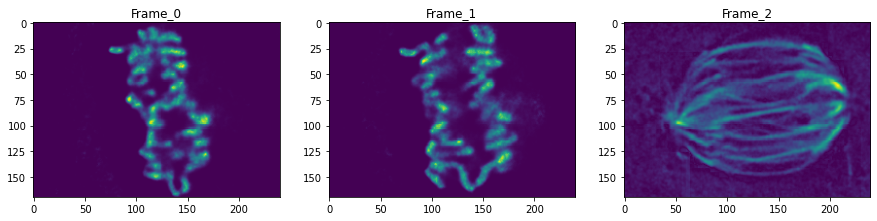

In [12]:
with pyczi.open_czi(czifile_5dstack) as czi_doc:
    plane_1 = {'C': 0, 'Z': 2, 'T': 1}
    plane_2 = {'C': 1, 'Z': 3, 'T': 2}

    frame_0 = czi_doc.read() # equivalent to reading {'C': 0, 'Z': 0, 'T': 0}
    frame_1 = czi_doc.read(plane=plane_1)
    frame_2 = czi_doc.read(plane=plane_2)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(frame_0)
    ax[0].set_title("Frame_0")
    ax[1].imshow(frame_1)
    ax[1].set_title("Frame_1")
    ax[2].imshow(frame_2)
    ax[2].set_title("Frame_2")

### Read ROI in the 2D plane
We can also read an ROI within the plane.
This is particularly useful when dealing with large images whose planes would not fit into memory.

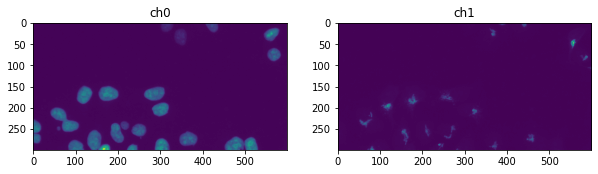

In [18]:
my_roi = (200, 400, 600, 300)

with pyczi.open_czi(czifile_scenes) as czi_doc:
    ch0 = czi_doc.read(roi=my_roi, plane={'C': 0})
    ch1 = czi_doc.read(roi=my_roi, plane={'C': 1})

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(frame_ch0)
    ax[0].set_title("ch0")
    ax[1].imshow(frame_ch1)
    ax[1].set_title("ch1")

### Read ROI only for one scene
We can also get pixel data exclusively from one scene only using the scene parameter.

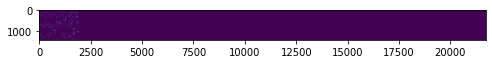

In [21]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    frame = czi_doc.read(roi=total_bounding_rectangle, scene=0)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(frame)

If we specify a scene, the ROI will default that scene's bounding rectangle. This helps simplify the code as seen below:

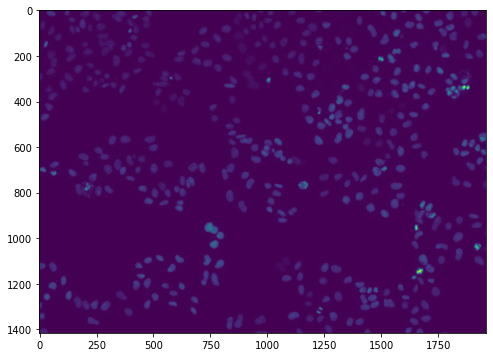

In [22]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    frame_s0 = czi_doc.read(scene=0)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(frame_s0)

### Additional parameters

We can specify the pixel type in which we want the data. If we don't specify any, the data is returned in its original pixel format.
The shape of the numpy array will naturally depend on the chosen pixel type.

In [23]:
with pyczi.open_czi(czifile_5dstack) as czi_doc:
    frame_gray8 = czi_doc.read(pixel_type='Gray8')
    frame_gray32float = czi_doc.read(pixel_type='Gray32Float')
    frame_bgr48 = czi_doc.read(pixel_type='Bgr48')

    print('shape {0}, data type {1}'.format(frame_gray8.shape, frame_gray8.dtype))
    print('shape {0}, data type {1}'.format(frame_gray32float.shape, frame_gray32float.dtype))
    print('shape {0}, data type {1}'.format(frame_bgr48.shape, frame_bgr48.dtype))

shape (170, 240, 1), data type uint8
shape (170, 240, 1), data type float32
shape (170, 240, 3), data type uint16


We can also specify a zoom factor between 0 and 1:

In [ ]:
with pyczi.open_czi(czifile_scenes) as czi_doc:
    frame_0 = czi_doc.read(zoom=1, pixel_type='Gray8')
    frame_1 = czi_doc.read(zoom=0.1, pixel_type='Gray8')

    fig, ax = plt.subplots(1, 2, figsize=(150, 150))
    ax[0].imshow(frame_0.squeeze())
    ax[1].imshow(frame_1.squeeze())

And a background colour, which of course needs to match the returned pixel type.

In [ ]:
with czi.open_czi(demo_czi_read) as czi_doc:
    black_background = (0, 0, 0) #black
    other_background = (255, 0, 0) #red

    frame_0 = czi_doc.read(background_pixel=black_background)
    frame_1 = czi_doc.read(background_pixel=other_background)

    fig, ax = plt.subplots(2, 1, figsize=(150, 150))
    ax[0].imshow(frame_0)
    ax[1].imshow(frame_1)

## Writing a CZI file

The writing API only allows creating new czi files. Editing existing czi file is not supported.
The writing API is somewhat symmetrical to the reading API.

### Create a new CZI
Similarly to reading, before writing, we must create a czi instance. We can then write to the created instance.

### Write data
Writing pixel data is very similar to reading albeit with fewer parameters.

We can define the plane to which we want to write the data.

The data to be written is also provided as a numpy array,
and the pixel type in which it is written is automatically determined from the shape of the array and its data type.

So let's write two channels with different pixel types:

In [ ]:
import numpy as np

demo_czi_write = r'D:\pylibCZIrw_demo\demo_write_0.czi'

with czi.create_czi(demo_czi_write) as new_czi_doc:
    plane_0 = {'C': 0}
    plane_1 = {'C': 1}
    data_gray8 = np.random.randint(255, size=(1024,1024,1),dtype=np.uint8)
    data_bgr24 = np.random.randint(255, size=(1024,1024,3),dtype=np.uint8)

    new_czi_doc.write(data=data_gray8, plane=plane_0)
    new_czi_doc.write(data=data_bgr24, plane=plane_1)

We can also write data to a specific location within the plane by providing the upper left pixel coordinates.
Let's write more data but at a different locations:

In [ ]:
demo_czi_write = r'D:\pylibCZIrw_demo\demo_write_1.czi'

with czi.create_czi(demo_czi_write) as new_czi_doc:
    new_czi_doc.write(data=data_gray8, plane=plane_0)
    new_czi_doc.write(data=data_gray8, plane=plane_0, location=(2000, 2000))

### Write scenes

Writing a scene is nothing other than writing data and tagging it with a scene index. The scene index defaults to zero.
Let's write a scene to the same plane:

In [ ]:
demo_czi_write = r'D:\pylibCZIrw_demo\demo_write_scenes.czi'

with czi.create_czi(demo_czi_write) as new_czi_doc:
    new_czi_doc.write(data=data_gray8, plane=plane_0, scene=0)
    #test
    new_czi_doc.write(data=data_gray8, plane=plane_0, location=(2000, 0), scene=1)

### Write Metadata

It is possible to write metadata and even provide the following optional parameters:

- document name
- channel names
- scaling in µm (scale_x, scale_y, scale_z

This list of parameters will be extended on a case-by-case basis.

In [ ]:
demo_czi_write = r'D:\pylibCZIrw_demo\demo_write_metdata.czi'

with czi.create_czi(demo_czi_write) as new_czi_doc:
    new_czi_doc.write(data=data_gray8, plane={'C': 0})
    new_czi_doc.write(data=data_gray8, plane={'C': 1})
    plane_1 = {'C': 1}
    new_czi_doc.write_metadata(
        document_name='foo',
        channel_names={ 0: "foo", 1: "bar" },
        scale_x=1, scale_y=2, scale_z=3
    )

If no metadata was written, the default metadata is automatically written upon closing the document.

## Tiling a large image

The read and write API allow us to work with large images by breaking down the access into "tiles".
However, defining this tiles can be a cumbersome process.

The [czitile](https://dev.azure.com/ZEISSgroup/RMS-DEV/_git/RMS_PyPI_CZTile) package was created to answer this need.

This package contains pure logic for tiling rectangles and is not IO nor format bound.

Let's read the original file using cztile and write a new with the same dimensions and scenes but with
random data instead.

In [ ]:
from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D

demo_czi_write = r'D:\pylibCZIrw_demo\copy_with_random_data.czi'

with czi.open_czi(demo_czi_read) as czi_doc_r:
    with czi.create_czi(demo_czi_write) as czi_doc_w:
        # define tile strategy
        tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(
            total_tile_width=450,
            total_tile_height=450,
            min_border_width=15
        )

        # tile scene bounding rectangles instead of the whole 2D plane
        for scene_index in czi_doc_r.scenes_bounding_rectangle.keys():
            tiles = tiler.tile_rectangle(czi_doc_r.scenes_bounding_rectangle[scene_index])
            for t in range(czi_doc_r.total_bounding_box['T'][1]):
                for z in range(czi_doc_r.total_bounding_box['Z'][1]):
                    for c in range(czi_doc_r.total_bounding_box['C'][1]):
                        for tile in tiles:
                            #write non-overlapping data
                            # data = np.random.randint(255, size=(tile.center.h, tile.center.w, 1), dtype=np.uint8)
                            # czi_doc_w.write(
                            #     data,
                            #     location=(tile.center.x, tile.center.y),
                            #     plane={'C': c, 'Z': z, 'T': t},
                            #     scene=scene_index)
                            #write overlapping data
                            data = np.random.randint(255, size=(tile.roi.h, tile.roi.w, 1), dtype=np.uint8)
                            czi_doc_w.write(
                                data,
                                location=(tile.roi.x, tile.roi.y),
                                plane={'C': c, 'Z': z, 'T': t},
                                scene=scene_index)